In [1]:
import pandas as pd
import experiment.preprocess as preprocess
from candidates_generation import triple_gen
import importlib
import numpy as np

In [2]:
path ='data/codex-m/data_sample.csv'
df = pd.read_csv(path)
evaluation_df, candidates_df, missing_df = preprocess.create_experiment_df(path)

/Users/fieng/Project/KGC_RAG/experiment/preprocess.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_cand_df['Missing'] = 1
/Users/fieng/Project/KGC_RAG/experiment/preprocess.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_cand_df['Missing'] = 0


In [ ]:
import experiment.filtering as filtering

filtred_df = filtering.create_filtred_df(df, evaluation_df, missing_df)

In [3]:
from candidates_filtering.embedding import train_model

train_df = train_model.create_dataset(
    df)
test_df = train_model.create_dataset(
    df.sample(n=50))
embedding_dim = 512
model_kwargs = {"embedding_dim": embedding_dim}

model_name = 'TransE'
experiment_name = model_name+f"_dim{embedding_dim}"
model = train_model.create_pipeline(train_df, test_df,
                    model_name, model_kwargs, experiment_name)

model_dict = {}

model_dict['TransE'] = model


/Users/fieng/Project/KGC_RAG/langchain-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fieng. Use `wandb login --relogin` to force relogin


No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 50/50 [05:11<00:00,  6.24s/epoch, loss=2.01, prev_loss=2.05]
Evaluating on cpu:   0%|          | 0.00/50.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:00<00:00, 73.4triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.86s seconds


loss,▃▁▃▃█▅▁▄▅▅▃▆▄▅▆▅▃▅▅▅▆▅▄▅▅▄▅▅▅▄▅▆▅▇▆▅▇▅▅▃
testing.both.optimistic.adjusted_arithmetic_mean_rank,▁
testing.both.optimistic.adjusted_arithmetic_mean_rank_index,▁
testing.both.optimistic.adjusted_geometric_mean_rank_index,▁
testing.both.optimistic.adjusted_hits_at_k,▁
testing.both.optimistic.adjusted_inverse_harmonic_mean_rank,▁
testing.both.optimistic.arithmetic_mean_rank,▁
testing.both.optimistic.count,▁
testing.both.optimistic.geometric_mean_rank,▁
testing.both.optimistic.harmonic_mean_rank,▁
testing.both.optimistic.hits_at_1,▁


In [5]:
model_name = 'ConvE'
from pykeen.triples import TriplesFactory


train_df = TriplesFactory.from_labeled_triples(
    df[["Head", "Relation", "Tail"]].values,
    create_inverse_triples=True,
    entity_to_id=None,
    relation_to_id=None,
    compact_id=True,
    filter_out_candidate_inverse_relations=True,
    metadata=None,
    )
test_df = TriplesFactory.from_labeled_triples(
    df[["Head", "Relation", "Tail"]].sample(50).values,
    create_inverse_triples=True,
    entity_to_id=None,
    relation_to_id=None,
    compact_id=True,
    filter_out_candidate_inverse_relations=True,
    metadata=None,
    )
experiment_name = model_name+f"_dim{embedding_dim}"
model = train_model.create_pipeline(train_df, test_df,
                    model_name, model_kwargs, experiment_name)
model_dict['ConvE'] = model

loss,█▆▆▆▅▅▄▄▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
loss,0.05125


INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.modules:Resolving None * None * None = 512.
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/468 (0.21%) batches).
Training epochs on cpu: 100%|██████████| 50/50 [1:50:50<00:00, 133.01s/epoch, loss=0.0077, prev_loss=0.00385] 
Evaluating on cpu:   0%|          | 0.00/50.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:00<00:00, 67.2triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.92s seconds


loss,█▇▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing.both.optimistic.adjusted_arithmetic_mean_rank,▁
testing.both.optimistic.adjusted_arithmetic_mean_rank_index,▁
testing.both.optimistic.adjusted_geometric_mean_rank_index,▁
testing.both.optimistic.adjusted_hits_at_k,▁
testing.both.optimistic.adjusted_inverse_harmonic_mean_rank,▁
testing.both.optimistic.arithmetic_mean_rank,▁
testing.both.optimistic.count,▁
testing.both.optimistic.geometric_mean_rank,▁
testing.both.optimistic.harmonic_mean_rank,▁
testing.both.optimistic.hits_at_1,▁


In [6]:
from candidates_filtering.embedding.get_emb_transe import get_list_dist
model = model_dict['ConvE'] 
list_dist = get_list_dist(evaluation_df,model.model, train_df)
evaluation_df['ConvE'] = list_dist

In [12]:
model = model_dict['TransE'] 
list_dist = get_list_dist(evaluation_df,model.model, train_df)
evaluation_df['TransE'] = list_dist

In [27]:
from sklearn.model_selection import train_test_split

val_df, testing_df = train_test_split(evaluation_df, test_size=0.4, random_state=42)



In [15]:
model = model_dict['ConvE'] 

In [28]:
print('Not missing data')
print(np.mean(val_df['Transe'][val_df['Missing'] == 0]))
print('Missing data')
print(np.mean(val_df['Transe'][val_df['Missing'] == 1]))

Not missing data
11.761274
Missing data
12.316602


In [61]:
evaluation_df

,Head,Relation,Tail,Missing,TransE,ConvE score
0,"""Weird Al"" Yankovic",occupation,executive producer,0,12.765949,-9.912884
1,A. Q. Khan,occupation,metallurgist,1,14.395555,-8.906730
2,A.J. Trauth,educated at,Ludwig Maximilian University of Munich,0,12.174455,-14.321050
3,AJ Michalka,occupation,non-fiction writer,0,13.611296,-12.011340
4,Abigail Breslin,country of citizenship,Cuba,0,13.789470,-8.555943
...,...,...,...,...,...,...
1995,Éamon de Valera,employer,University of Zurich,0,10.892023,-3.619811
1996,Édouard Baer,educated at,Cours Florent,1,12.500125,-12.425575
1997,Émile Achard,country of citizenship,United States of America,0,12.243021,-4.504884
1998,Émile Chartier,movement,free-thought,0,7.113543,-9.474366


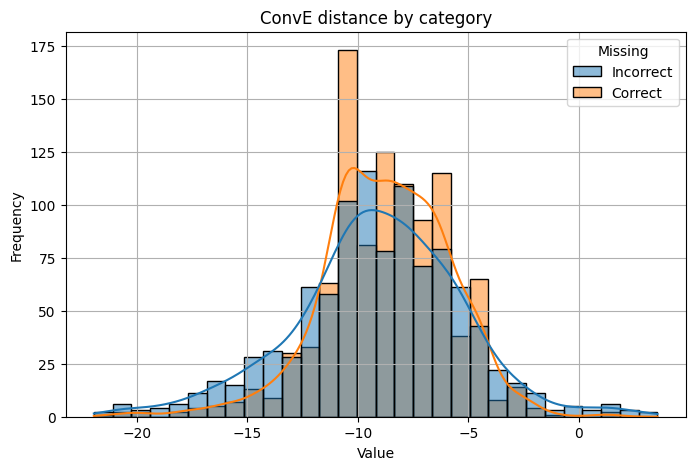

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate sample data
data = evaluation_df.copy()
data["Missing"] = data["Missing"].replace({0: "Incorrect", 1: "Correct"})


# Create the distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(data, x="ConvE score", hue="Missing", kde=True, bins=30, alpha=0.5)

# Customize the plot
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("ConvE distance by category")
plt.grid()

# Show the plot
plt.show()


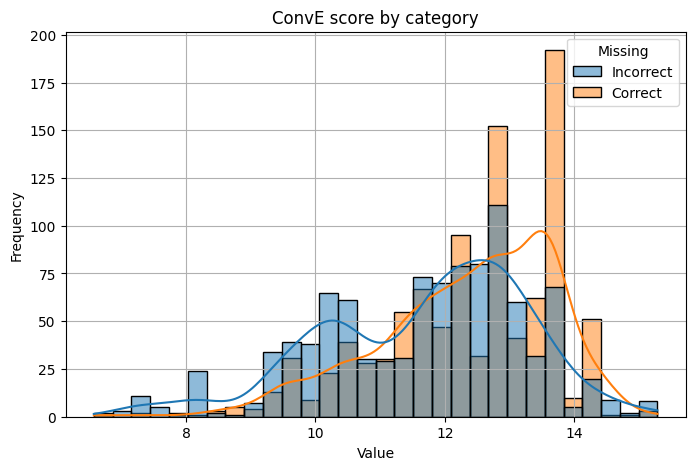

In [63]:
# Generate sample data
data = evaluation_df.copy()
data["Missing"] = data["Missing"].replace({0: "Incorrect", 1: "Correct"})


# Create the distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(data, x="TransE", hue="Missing", kde=True, bins=30, alpha=0.5)

# Customize the plot
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("ConvE score by category")
plt.grid()

# Show the plot
plt.show()


In [23]:
from pykeen.predict import predict_triples

eval_test_df = train_model.create_dataset(
    evaluation_df[['Head','Relation','Tail']])
pack = predict_triples(model=model.model, triples= eval_test_df)


In [46]:
score_df = pack.process(factory=eval_test_df).df


In [47]:
score_df[['head_label','relation_label','tail_label','score']]

,head_label,relation_label,tail_label,score
0,"""Weird Al"" Yankovic",occupation,executive producer,-9.912884
1,A. Q. Khan,occupation,metallurgist,-8.906730
2,A.J. Trauth,educated at,Ludwig Maximilian University of Munich,-14.321050
3,AJ Michalka,occupation,non-fiction writer,-12.011340
4,Abigail Breslin,country of citizenship,Cuba,-8.555943
...,...,...,...,...
1995,Éamon de Valera,employer,University of Zurich,-3.619811
1996,Édouard Baer,educated at,Cours Florent,-12.425575
1997,Émile Achard,country of citizenship,United States of America,-4.504884
1998,Émile Chartier,movement,free-thought,-9.474366


In [48]:
score_df['Head'] = score_df['head_label']
score_df['Relation'] = score_df['relation_label']
score_df['Tail'] = score_df['tail_label']

In [49]:
merged_df = score_df.merge(evaluation_df, on=['Head','Relation','Tail'], how="inner")

In [58]:
evaluation_df = merged_df[['Head','Relation','Tail','Missing','TransE','score']]
evaluation_df['ConvE score'] = evaluation_df['score']
evaluation_df = evaluation_df[['Head','Relation','Tail','Missing','TransE','ConvE score']]

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_2542/1331545834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['ConvE score'] = evaluation_df['score']


In [59]:
evaluation_df

,Head,Relation,Tail,Missing,TransE,ConvE score
0,"""Weird Al"" Yankovic",occupation,executive producer,0,12.765949,-9.912884
1,A. Q. Khan,occupation,metallurgist,1,14.395555,-8.906730
2,A.J. Trauth,educated at,Ludwig Maximilian University of Munich,0,12.174455,-14.321050
3,AJ Michalka,occupation,non-fiction writer,0,13.611296,-12.011340
4,Abigail Breslin,country of citizenship,Cuba,0,13.789470,-8.555943
...,...,...,...,...,...,...
1995,Éamon de Valera,employer,University of Zurich,0,10.892023,-3.619811
1996,Édouard Baer,educated at,Cours Florent,1,12.500125,-12.425575
1997,Émile Achard,country of citizenship,United States of America,0,12.243021,-4.504884
1998,Émile Chartier,movement,free-thought,0,7.113543,-9.474366
